In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, models

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
# Downloading the vgg19 modal and freezing all the parameters

vgg = models.vgg19(pretrained=True).features
for params in vgg.parameters():
    params.requires_grad_(False)

In [122]:
# checking if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [123]:
# helper function to load the image and transform it into Tensors
# The paper uses an image of size 512x512

def image_loader(img_path, max_size=512, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    # https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/10
    im_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.225, 0.225))
    ])
    
    # In images with an alpha channel, each pixel not only has a color value, but also has a numerical 
    # transparency value that defines what will happen when the pixel is placed over another pixel.
    
    # discard transparent alpha channela and add batch dimensions
    image = im_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [124]:
def tensor_to_image(tensor):
    
    # constructs a new view on a tensor which is declared not to need gradients,
    # i.e., it is to be excluded from further tracking of operations
    img = tensor.to("cpu").clone().detach()
    
    # convert the image to numpy and remove an extra dimension
    img = img.numpy().squeeze()
    
    img = img.transpose(1,2,0)
    
    # Unnormalize the image
    img = img * np.array((0.229, 0.224, 0.225)) +  np.array((0.485, 0.456, 0.406))
    
    img  = img.clip(0,1)
    
    return img

In [125]:
# load in content and style image
content = image_loader('images/content/main-building.jpg', shape=(512,512)).to(device)

style = image_loader('images/style/starry-night.jpg', shape=(512,512)).to(device)

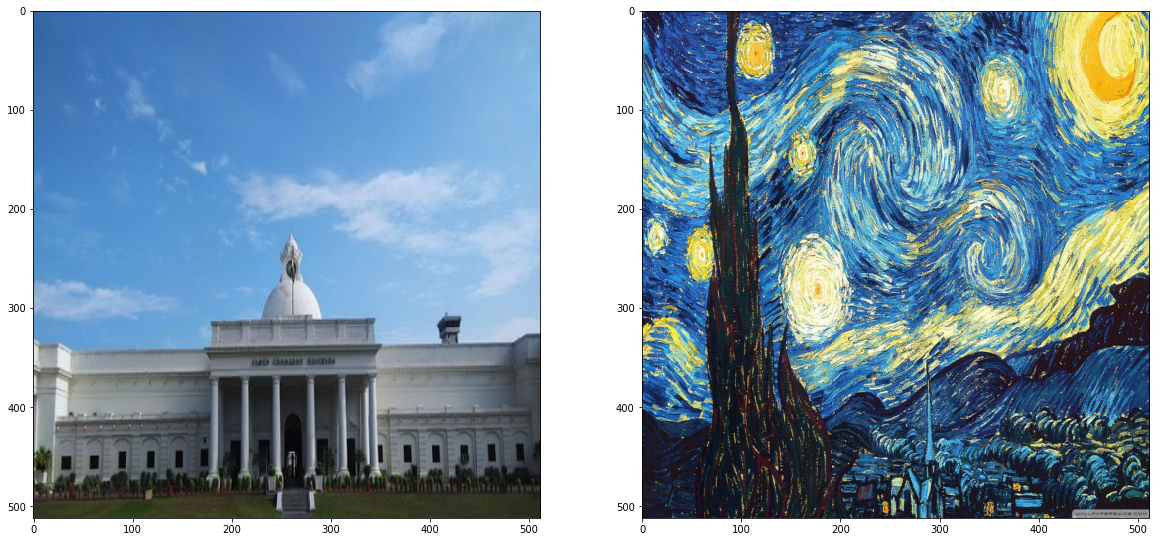

In [126]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(tensor_to_image(content))
ax2.imshow(tensor_to_image(style))

In [127]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0' : 'conv1_1',
            '5' : 'conv2_1',
            '10': 'conv3_1', 
            '19': 'conv4_1',
            '21': 'conv4_2',  ## content representation
            '28': 'conv5_1'
        }
    
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
#         print (layer)
        if name in layers:
            features[layers[name]] = x
    return features

In [128]:
# vgg._modules.items()

In [129]:
def gram_matrix(tensor):
    
    _, d, w, h = tensor.shape
    
    tensor = tensor.view(d, h*w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [130]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [131]:
# content_features

In [132]:

# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  16267824.0


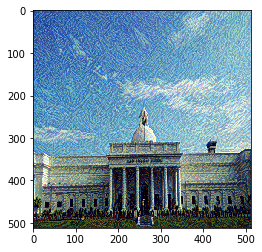

Total loss:  6931053.5


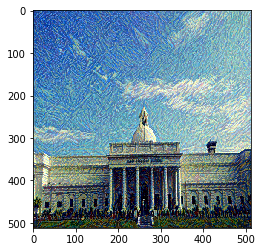

Total loss:  3729783.0


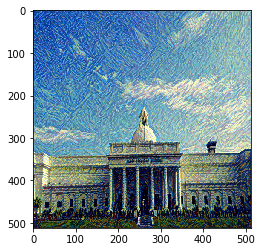

Total loss:  2352503.0


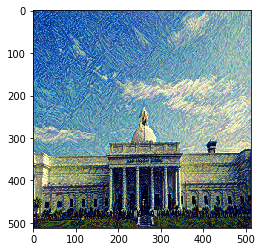

Total loss:  1643352.75


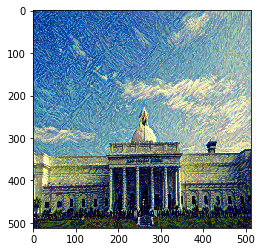

Total loss:  1208234.5


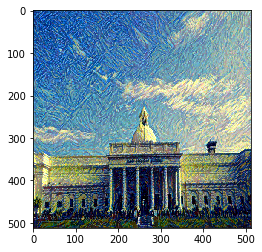

Total loss:  918479.6875


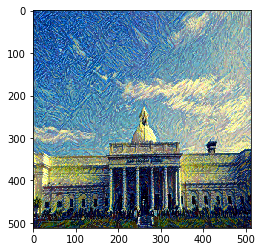

Total loss:  720742.25


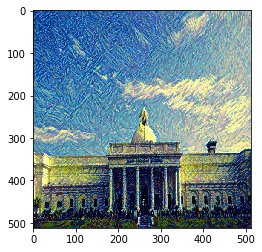

Total loss:  582830.4375


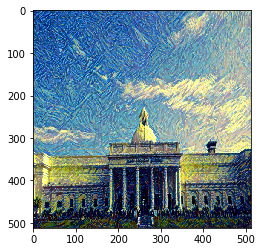

Total loss:  483563.09375


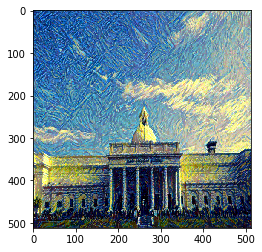

In [134]:
# for displaying the target image, intermittently
show_every = 200

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
#     print (target_features)
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(tensor_to_image(target))
        plt.show()